In [1]:
import torch
from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [2]:
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [3]:
from dotenv import load_dotenv
import os

In [4]:
from torchvision.utils import make_grid

In [5]:
from torch.utils.tensorboard import SummaryWriter

In [6]:
load_dotenv()

True

Utils

In [7]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [8]:
def get_data(input_path):
    norm = [0.5, 0.5, 0.5]

    data_transforms = {
        'train':
        transforms.Compose([
            transforms.Resize((150,150)),
            # transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(norm, norm)
        ]),
        'validation':
        transforms.Compose([
            transforms.Resize((150,150)),
            transforms.ToTensor(),
            transforms.Normalize(norm, norm)
        ]),
    }

    image_datasets = {
        'train': 
        datasets.ImageFolder(os.path.join(input_path,'train'), data_transforms['train']),
        'validation': 
        datasets.ImageFolder(os.path.join(input_path,'valid'), data_transforms['validation'])
    }

    dataloaders = {
        'train':
        torch.utils.data.DataLoader(image_datasets['train'],
                                    batch_size=64,
                                    shuffle=True),
        'validation':
        torch.utils.data.DataLoader(image_datasets['validation'],
                                    batch_size=64,
                                    shuffle=False)
    }
    return dataloaders, image_datasets

In [9]:
from tqdm import tqdm

In [10]:
def train_model(model, criterion, optimizer, dataloaders, image_datasets, num_epochs=3):
    tb = SummaryWriter()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            with tqdm(total=dataloaders[phase].dataset.samples.__len__()) as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)                    
                
                    pbar.update(labels.__len__())
            tb.add_scalar("Loss", running_loss, epoch)
            tb.add_scalar("Correct", running_corrects, epoch)
            tb.add_scalar("Accuracy", running_corrects/ len(image_datasets[phase]), epoch)
            for name, weight in model.named_parameters():
                tb.add_histogram(name,weight, epoch)
                tb.add_histogram(f'{name}.grad',weight.grad, epoch)
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    tb.close()
    return model

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Compare datasets

In [12]:
os.listdir(os.path.join(os.getenv('data_path'),'baza_student_raw'))

['abdul_cbis_vindr_bcd_four_classes_augment',
 'cbis_ddsm_four_classes_augment',
 'patch_ddsm_four_classes_augment',
 'vindr_four_classes_dark_augment']

# ABDUL VINDR

In [13]:
model = models.resnet50(pretrained=True).to(device)
# model = models.vgg16(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = True   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [14]:
dataloaders, image_datasets = get_data(os.path.join(os.getenv('data_path'),'baza_student_raw','abdul_cbis_vindr_bcd_four_classes_augment'))

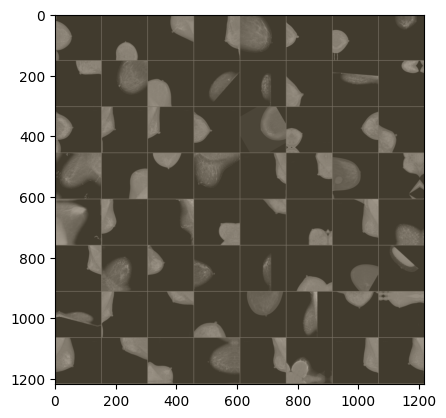

In [16]:
# Get a batch of training data
images, labels = next(iter(dataloaders['train']))
# Make a grid from batch
grid = make_grid(images)
imshow(grid)

In [17]:
model_abdul = train_model(model, criterion, optimizer, dataloaders, image_datasets, num_epochs=10)

Epoch 1/10
----------


  0%|          | 0/37701 [00:00<?, ?it/s]

In [ ]:
torch.save(model_abdul.state_dict(), 'models/model_abdul/weights.h5')

# CBIS

In [88]:
model = models.resnet50(pretrained=True).to(device)
# model = models.vgg16(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = True   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Tarasiuk/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [84]:
dataloaders, image_datasets = get_data(os.path.join(os.getenv('data_path'),'baza_student_raw','cbis_ddsm_four_classes_augment'))

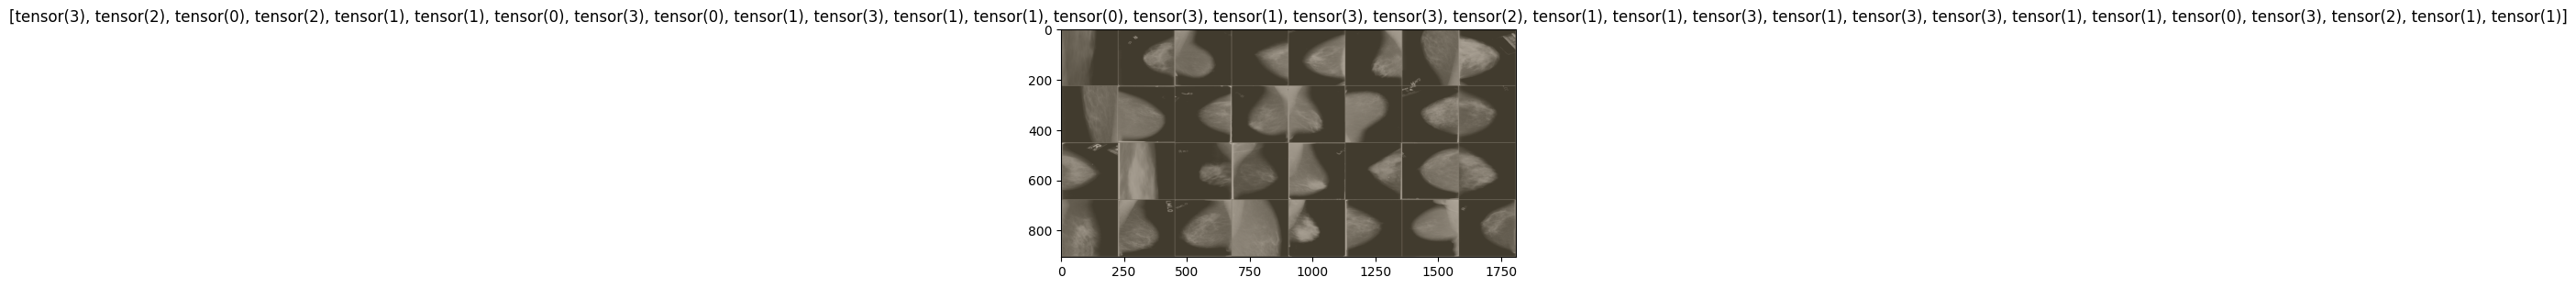

In [61]:
# Get a batch of training data
images, labels = next(iter(dataloaders['train']))
# Make a grid from batch
grid = make_grid(images)
imshow(grid,title=[x for x in labels])

In [55]:
tb = SummaryWriter()
tb.add_image("images", grid)
tb.add_graph(model, images)
tb.close()

In [89]:
model_cbis = train_model(model, criterion, optimizer, dataloaders, image_datasets, num_epochs=3)

Epoch 1/3
----------


  0%|          | 0/312 [00:02<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x512 and 2048x128)

In [57]:
!tensorboard --logdir runs

^C


In [ ]:
torch.save(model_cbis.state_dict(), 'models/model_cbis/weights.h5')

# patch ddsm

In [ ]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = True   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

Using cache found in C:\Users\Tarasiuk/.cache\torch\hub\pytorch_vision_v0.10.0


In [ ]:
dataloaders, image_datasets = get_data(os.path.join(os.getenv('data_path'),'baza_student_raw','patch_ddsm_four_classes_augment'))

FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: 'C:\\Users\\Tarasiuk\\Desktop\\federated_learning_demo\\data\\baza_student_raw\\path_ddsm_four_classes_augment\\train'

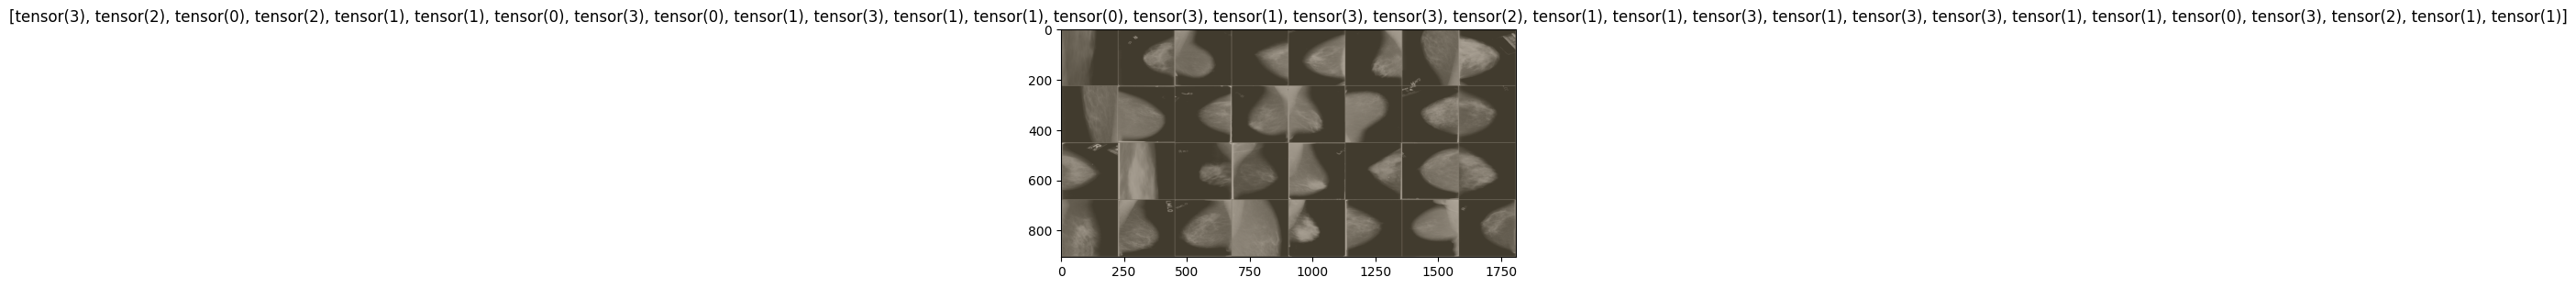

In [ ]:
# Get a batch of training data
images, labels = next(iter(dataloaders['train']))
# Make a grid from batch
grid = make_grid(images)
imshow(grid,title=[x for x in labels])

In [ ]:
model_ddsm = train_model(model, criterion, optimizer, dataloaders, image_datasets, num_epochs=30)

Epoch 1/30
----------
train loss: 1.4408, acc: 0.2949
validation loss: 1.4692, acc: 0.3333
Epoch 2/30
----------
train loss: 1.2346, acc: 0.4263
validation loss: 1.2614, acc: 0.4630
Epoch 3/30
----------
train loss: 1.0872, acc: 0.5609
validation loss: 1.3729, acc: 0.3704
Epoch 4/30
----------
train loss: 0.9986, acc: 0.5994
validation loss: 1.2288, acc: 0.4630
Epoch 5/30
----------
train loss: 0.9077, acc: 0.6538
validation loss: 1.1463, acc: 0.4444
Epoch 6/30
----------


In [ ]:
torch.save(model_ddsm.state_dict(), 'models/model_ddsm/weights.h5')

# VINDR

In [ ]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = True   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [ ]:
dataloaders, image_datasets = get_data(os.path.join(os.getenv('data_path'),'baza_student_raw','vindr_four_classes_augment'))

In [ ]:
model_vindr = train_model(model, criterion, optimizer, dataloaders, image_datasets, num_epochs=30)

Epoch 1/3
----------


In [ ]:
torch.save(model_vindr.state_dict(), 'models/model_vindr/weights.h5')